In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # my kernel dies sometimes this prevents it
import json
from timeit import default_timer as timer  #for checking run time
from datetime import timedelta
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
f = open('sorular.json','r',encoding="utf-8")
data = json.loads(f.read())

In [3]:
allqu=[s for i,s in data.items()]

In [4]:
len(allqu)  # total question

500

In [5]:
allqu[0].split()   #this is general processing sample

['En', 'sevdiğin', 'tatil', 'beldesi', 'neresi?']

In [6]:
proque=[]
for i in allqu:    #First Pre-processing just taking capital letters and dividing question marks away from words
    i=i.strip('(,?,),(') + " ?"  #data has lots of useless symbols
    i = i.lower()
    i = " " + i
    proque.append(i)
    print(i)   
    

 en sevdiğin tatil beldesi neresi ?
 kendini bir karaktere benzetseydin, hangisi olurdun ?
 hayatında en çok neye şükredersin ?
 en sevdiğin müzik tarzı hangisi ?
 en çok hangi hayvanı seviyorsun ?
 en çok hangi yemek tarzını seversin ?
 en çok hangi filmden etkiledin ?
 hayatında başarı olarak gördüğün en büyük anın neydi ?
 en sevdiğin kitap nedir ?
 seni en çok ne mutlu eder ?
 hangi sporu seversin ?
 hangi tarihi döneme gitmek istersin ?
 en sevdiğin yılbaşı gelenekleri nelerdir ?
 hangi şehirde yaşamayı hayal edersin ?
 hayatında en çok nelerden keyif alırsın ?
 hangi mevsim senin favorin ?
 en sevdiğin yemek tarifi nedir ?
 hangi müze veya sanat galerisini gezmek istersin ?
 seni en çok neyin korkutur ?
 bir süper güce sahip olabilseydin, hangisini seçerdin ?
 en sevdiğin renk nedir ?
 hangi dili öğrenmek istersin ?
 hangi hayat felsefesine sahipsin ?
 hayatta yapmak istediğin ilk şey nedir ?
 hangi sosyal medya platformunda en çok zaman geçiriyorsun ?
 en sevdiğin çikolata çeşid

In [7]:
#we need to enumerate all of the words in to a dictionary and putting "?" also at index zero 

allwords = ''.join(proque).split()  #for getting unique words first put all sentences together then split them
print(f"All word counts: {len(allwords)}")
allwords=sorted(list(set(allwords)))
allwords.remove('?')  #this is actually little useles to be honest

wi = {w:i+1 for i,w in enumerate(allwords)}    #word to index
wi['?'] = 0

iw = {i:w for w,i in wi.items()}    #index to word
print(f"Unique Word Counts :{len(iw)}")






All word counts: 3485
Unique Word Counts :824


As you can see from above we have only 3485 words in 500 question and unfortunately 824 of them unique words; so we need to create a some sort of bias

In theory we might use high numbers of batch sizes but when i tried this i didnt get results that i expected.
So what i did is actually letting model overfit :D and that kinda worked
in codes below you might want to  change iteration,neurons,learning rate

In [8]:
len(wi)

824

In [9]:
for q in range(len(proque)):
    proque[q] = proque[q].lstrip()  #second Pre-processing
proque[:10]

['en sevdiğin tatil beldesi neresi ?',
 'kendini bir karaktere benzetseydin, hangisi olurdun ?',
 'hayatında en çok neye şükredersin ?',
 'en sevdiğin müzik tarzı hangisi ?',
 'en çok hangi hayvanı seviyorsun ?',
 'en çok hangi yemek tarzını seversin ?',
 'en çok hangi filmden etkiledin ?',
 'hayatında başarı olarak gördüğün en büyük anın neydi ?',
 'en sevdiğin kitap nedir ?',
 'seni en çok ne mutlu eder ?']

In [10]:
oneq=proque[0]
for q in oneq.split():
    print(q)

en
sevdiğin
tatil
beldesi
neresi
?


In [11]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(proque):  
  X, Y = [], []
  for q in proque:

    
    context = [0] * block_size
    for w in q.split():
      ix = wi[w]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)      #good ol' random seed 42 idk why people using this specific seed 
random.shuffle(proque)
n1 = int(0.8*len(proque))
n2 = int(0.9*len(proque))

Xtr, Ytr = build_dataset(proque[:n1])
Xdev, Ydev = build_dataset(proque[n1:n2])
Xte, Yte = build_dataset(proque[n2:])


torch.Size([2772, 3]) torch.Size([2772])
torch.Size([363, 3]) torch.Size([363])
torch.Size([350, 3]) torch.Size([350])


In [34]:
g = torch.Generator().manual_seed(214748472) # for reproducibility
C = torch.randn((824, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 824), generator=g)
b2 = torch.randn(824, generator=g)
parameters = [C, W1, b1, W2, b2]

In [35]:
sum(p.nelement() for p in parameters)

180064

In [36]:
for p in parameters:
  p.requires_grad = True

In [37]:
C[Xtr[0]].shape

torch.Size([3, 10])

In [38]:
lre = torch.linspace(0, -3, 10000)
lrs = 10**lre
lrs

tensor([1.0000, 0.9993, 0.9986,  ..., 0.0010, 0.0010, 0.0010])

In [39]:
lossi = []
stepi = []
val_lossi=[]

In [40]:

start = timer()
for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  ix_val = torch.randint(0,Xdev.shape[0],(32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #validation loss
  emb2 = C[Xdev[ix_val]] # (32, 3, 2) #we are basically doubling the complexity for just seeing val loss
  h2 = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits2 = h2 @ W2 + b2 # (32, 27)
  loss2 = F.cross_entropy(logits2, Ydev[ix_val])
  val_lossi.append(loss2.log10().item())


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()   #for backpropagation grads are updated here
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())
end = timer()
print(f"\nRunning Time:{timedelta(seconds=end-start)}")


Running Time:0:00:27.294196


In [41]:
loss

tensor(0.4255, grad_fn=<NllLossBackward0>)

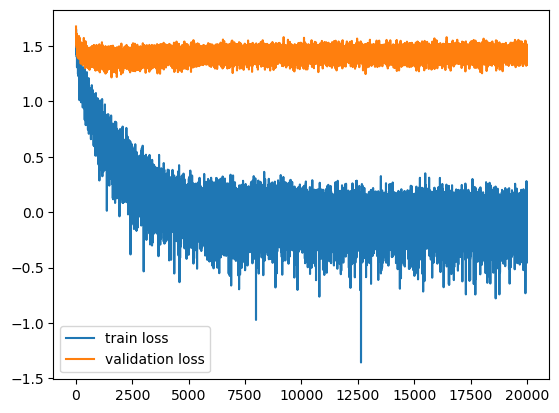

In [42]:
plt.plot(stepi, lossi,label = 'train loss')
plt.plot(stepi,val_lossi,label = 'validation loss')
plt.legend(loc=0) 
#this is a reaaaaly bad graph but whatever :)

In [43]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(0.8991, grad_fn=<NllLossBackward0>)

In [44]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(17.9171, grad_fn=<NllLossBackward0>)

In [267]:
countiee=0

for _ in range(50):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    
    la=' '.join(iw[i] for i in out)
    if la not in proque:
        countiee +=1
        print(la[0].upper()+la[1:])
print(f"\n\nNew Questions :{countiee} \nOverfitting questions :{_+1-countiee}")

Hangi renkler seni en çok etkiledi ?
Hangi şarkı türünü konserine zorluk mevsimi sorumluluk istersin ?
Bir süper güce sahip olmak isterdin ?
Hangi müzik tarzını en çok seversin ?
Hangi müze veya sergiyi ziyaret etmek istersin ve neden ?
Hangi kahramanlık hikayesi seni en çok motive eden şey nedir ?
En sevdiğin çeşidi bir nedir ?
Hangi aksanı bir tatil nasıl olmalıdır ?
Bir kitap okuyor musun ?
Hangi sosyal sorun seni en çok gururlandırır ?
Hayatında sana en çok ne mutlu eder ?


New Questions :11 
Overfitting questions :39


In [827]:
proque

['hangi konuda uzmanlaşmak istersin ve neden ?',
 'en sevdiğin yabancı film hangisi ?',
 'hangi duyguyu en sık yaşarsın ?',
 'hayatında yaptığın en büyük değişiklik neydi ?',
 'daha önce hiç yabancı bir ülkeye gittin mi? nereye gittin ?',
 'bir dil öğrenmek istesen hangisini öğrenmek isterdin? neden ?',
 'en son ne zaman ağladın? neden ?',
 'hangi korkunç film seni en çok etkiledi ?',
 'en sevdiğin renk nedir? hangi nesnede bu rengi görmek seni mutlu eder ?',
 'hangi filmi defalarca izlemişsindir ?',
 'en sevdiğin spor hangisi? neden ?',
 'hangi hayvanın sıradışı özellikleri seni etkiler ?',
 'hangi hobilerin var ?',
 'hangi kurgusal karakterle en iyi arkadaş olursun ?',
 'hangi evcil hayvanın sahibi olmak istersin ?',
 'hangi müzik aletini öğrenmek istersin ?',
 'en sevdiğin renk nedir? neden ?',
 'hangi tarihi dönemi daha çok merak edersin ?',
 'bir şarkı sözü yazacak olsan, ne hakkında olurdu ?',
 'hangi sporu yapmaktan hoşlanırsın ?',
 'hangi dilde bir şarkı yazmak istersin ?',
 'h

In [53]:
newi = {w:i+1 for w,i in wi.items()}
niw = {i:w for w,i in newi.items()}
niw  # new index to word

{2: '(deniz',
 3: 'afet',
 4: 'ailenle',
 5: 'aksanı',
 6: 'aktivite',
 7: 'aktiviteleri',
 8: 'aktivitesini',
 9: 'akıcı',
 10: 'akımını',
 11: 'alanda',
 12: 'alanında',
 13: 'aldın',
 14: 'aldığın',
 15: 'aleti',
 16: 'aletini',
 17: 'aletlerini',
 18: 'alırsın',
 19: 'alışkanlıkların',
 20: 'ama',
 21: 'an',
 22: 'anda?',
 23: 'animasyon',
 24: 'anlamlıdır',
 25: 'anlatır',
 26: 'anı',
 27: 'anın',
 28: 'anısı',
 29: 'araba',
 30: 'araştırmayı',
 31: 'arkadaş',
 32: 'arkadaşlığın',
 33: 'arkadaşın',
 34: 'artırabilecek',
 35: 'asla',
 36: 'atıyorsun',
 37: 'aynı',
 38: 'açacak',
 39: 'ağladın?',
 40: 'ağlattı',
 41: 'aşçının',
 42: 'aşık',
 43: 'aşıksın',
 44: 'bayılırsın',
 45: 'başarı',
 46: 'başarılı',
 47: 'başarın',
 48: 'başlamak',
 49: 'becerilerin',
 50: 'becerilerine',
 51: 'beceriyi',
 52: 'beldesi',
 53: 'benzediğin',
 54: 'benzediğini',
 55: 'benzetilirsin',
 56: 'benzetseydin,',
 57: 'benziyorsun?',
 58: 'bilgi',
 59: 'bilim',
 60: 'biliyorsun',
 61: 'bir',
 62: 'birin

In [54]:
seq=[]
for q in proque:
    low_seq = []
    for a in q.split():
        low_seq.append(newi[a])
    seq.append(low_seq)   
new_seq=[]
for a in seq:
    for i in range(1,len(a)):
        new_seq.append(a[:i+1])
new_seq 

[[259, 388],
 [259, 388, 580],
 [259, 388, 580, 154],
 [259, 388, 580, 154, 766],
 [259, 388, 580, 154, 766, 160],
 [259, 388, 580, 154, 766, 160, 1],
 [259, 425],
 [259, 425, 359],
 [259, 425, 359, 437],
 [259, 425, 359, 437, 233],
 [259, 425, 359, 437, 233, 332],
 [259, 425, 359, 437, 233, 332, 1],
 [259, 641],
 [259, 641, 516],
 [259, 641, 516, 629],
 [259, 641, 516, 629, 169],
 [259, 641, 516, 629, 169, 330],
 [259, 641, 516, 629, 169, 330, 1],
 [259, 472],
 [259, 472, 664],
 [259, 472, 664, 154],
 [259, 472, 664, 154, 766],
 [259, 472, 664, 154, 766, 589],
 [259, 472, 664, 154, 766, 589, 1],
 [259, 309],
 [259, 309, 711],
 [259, 309, 711, 332],
 [259, 309, 711, 332, 1],
 [259, 612],
 [259, 612, 85],
 [259, 612, 85, 46],
 [259, 612, 85, 46, 521],
 [259, 612, 85, 46, 521, 141],
 [259, 612, 85, 46, 521, 141, 1],
 [278, 572],
 [278, 572, 154],
 [278, 572, 154, 766],
 [278, 572, 154, 766, 317],
 [278, 572, 154, 766, 317, 675],
 [278, 572, 154, 766, 317, 675, 321],
 [278, 572, 154, 766,

In [55]:
max_seq_l = max(len(x) for x in new_seq)
max_seq_l

14

In [208]:
xs/100

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 2.59],
       [0.  , 0.  , 0.  , ..., 0.  , 2.59, 3.88],
       [0.  , 0.  , 0.  , ..., 2.59, 3.88, 5.8 ],
       ...,
       [0.  , 0.  , 0.  , ..., 2.59, 0.11, 3.78],
       [0.  , 0.  , 0.  , ..., 0.11, 3.78, 2.13],
       [0.  , 0.  , 0.  , ..., 3.78, 2.13, 3.32]])

In [56]:
new_sq= np.array(pad_sequences(new_seq,maxlen=max_seq_l,padding='pre'))
new_sq.shape

(2985, 14)

In [244]:
xs = new_sq[:,:-1]
#xs = xs/100   # for making gradients lower
labels = new_sq[:,-1]
print(f"xs {xs}\nlabels{labels}")

xs [[  0   0   0 ...   0   0 259]
 [  0   0   0 ...   0 259 388]
 [  0   0   0 ... 259 388 580]
 ...
 [  0   0   0 ... 259  11 378]
 [  0   0   0 ...  11 378 213]
 [  0   0   0 ... 378 213 332]]
labels[388 580 154 ... 213 332   1]


In [245]:
ys = to_categorical(labels, num_classes=825)
print(ys)
ys.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


(2985, 825)

In [246]:
#ys=F.one_hot(torch.tensor(labels).unsqueeze(0).to(torch.int64),825)  #Alternative way to one hot
#ys[0].shape

In [ ]:
ll=xs.shape[0]
ratio = 0.8  # 0.2 = valid data
#X_train = xs[:int(ll*0.8)]   
#X_valid = xs[int(ll*0.8):]    #This method is lacking randomness when choosing train/valid data
#Y_train =ys[:int(ll*0.8)]  
#Y_valid = ys[int(ll*0.8):]  


X_train, X_valid, Y_train, Y_valid = train_test_split(xs, ys, test_size=0.25, random_state=42)

la=[["X_train",X_train], ["X_valid",X_valid], ["Y_train",Y_train], ["Y_valid",Y_valid]]
for i in range(4):
    print(f"\n{la[i][0]} shape : {la[i][1].shape}")


In [247]:
model = Sequential()
model.add(Embedding(len(wi)+1, 124, input_length=max_seq_l-1))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(wi)+1, activation='softmax'))

In [248]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = callbacks.EarlyStopping(min_delta=0.009,patience=8,restore_best_weights=True,callbacks=[early_stopping])

In [251]:
start = timer()

history = model.fit(X_train,Y_train,validation_data=(X_valid,Y_valid),epochs=100,batch_size=32)

end = timer()
print(f"\nRunning Time:{timedelta(seconds=end-start)}")

Epoch 1/100
70/70 [==============================] - 14s 134ms/step - loss: 5.6057 - accuracy: 0.1510 - val_loss: 5.0951 - val_accuracy: 0.1861
Epoch 2/100
70/70 [==============================] - 8s 120ms/step - loss: 4.7526 - accuracy: 0.1988 - val_loss: 5.0222 - val_accuracy: 0.2169
Epoch 3/100
70/70 [==============================] - 8s 120ms/step - loss: 4.3797 - accuracy: 0.2592 - val_loss: 5.0002 - val_accuracy: 0.2838
Epoch 4/100
70/70 [==============================] - 8s 120ms/step - loss: 3.9934 - accuracy: 0.3070 - val_loss: 5.1451 - val_accuracy: 0.3025
Epoch 5/100
70/70 [==============================] - 8s 120ms/step - loss: 3.6725 - accuracy: 0.3342 - val_loss: 5.2011 - val_accuracy: 0.3119
Epoch 6/100
70/70 [==============================] - 8s 121ms/step - loss: 3.4595 - accuracy: 0.3405 - val_loss: 5.4966 - val_accuracy: 0.3079
Epoch 7/100
70/70 [==============================] - 8s 121ms/step - loss: 3.2858 - accuracy: 0.3525 - val_loss: 5.7625 - val_accuracy: 0.315

70/70 [==============================] - 10s 141ms/step - loss: 0.9854 - accuracy: 0.7172 - val_loss: 14.4639 - val_accuracy: 0.3347
Epoch 58/100
70/70 [==============================] - 10s 142ms/step - loss: 1.0177 - accuracy: 0.7127 - val_loss: 13.9777 - val_accuracy: 0.3213
Epoch 59/100
70/70 [==============================] - 10s 141ms/step - loss: 1.0235 - accuracy: 0.7136 - val_loss: 14.0727 - val_accuracy: 0.3253
Epoch 60/100
70/70 [==============================] - 10s 140ms/step - loss: 1.0353 - accuracy: 0.7221 - val_loss: 14.0004 - val_accuracy: 0.3119
Epoch 61/100
70/70 [==============================] - 10s 141ms/step - loss: 1.0153 - accuracy: 0.7109 - val_loss: 14.5609 - val_accuracy: 0.3186
Epoch 62/100
70/70 [==============================] - 10s 142ms/step - loss: 1.0301 - accuracy: 0.7172 - val_loss: 14.2964 - val_accuracy: 0.3213
Epoch 63/100
70/70 [==============================] - 10s 144ms/step - loss: 1.0606 - accuracy: 0.7078 - val_loss: 13.8724 - val_accuracy

Minimum Validation Loss: 5.0002
0.7381590604782104


<AxesSubplot:>

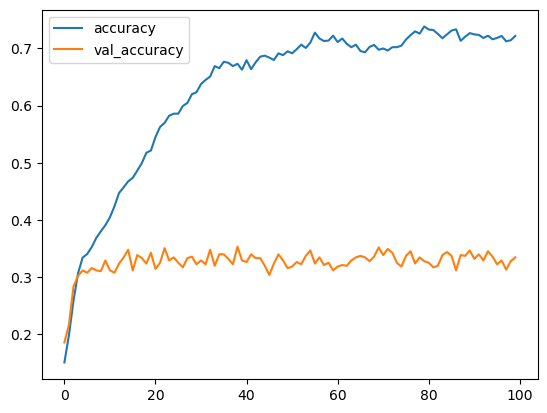

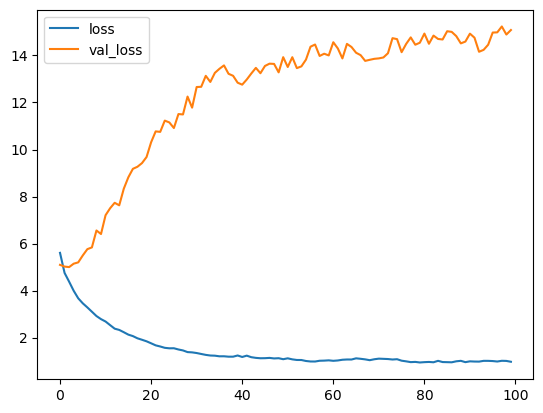

In [252]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));
print(history_df["accuracy"].max())
history_df.loc[:, ['loss', 'val_loss']].plot()

#Terrible terrible graphs unfortunately #But my goal was not perfection  and actually creating a sort of bias 
#thats achieved. I guess...


In [253]:
#First word choosing distribution

cnt = {}
for q in proque:
    for a in q.split()[:1]:
        cnt[(a,newi[a])] = cnt.get((a,newi[a]),0)+1

        
sorti=sorted(cnt.items(),key = lambda kv: -kv[1])[:11]   # after index 11 they only occured once or none at line[0]
morta = []
for a  in range(11):
    morta+=[sorti[a][0][1]]*sorti[a][1]
    
#for example 150 'hangi' and 100  'ne' times a questions starts then our list has 150 'hangi' and 100 'ne'


In [254]:
count.sum()

464

In [255]:
u,count=np.unique(np.array(morta),return_counts=True)
u=u[np.argsort(-count)]
count = count[np.argsort(-count)]
{niw[i]:c for i,c in list(zip(u,count))}

{'hangi': 291,
 'en': 85,
 'bir': 33,
 'hayatında': 17,
 'seni': 8,
 'hayatındaki': 7,
 'sana': 6,
 'daha': 5,
 'geçmişte': 5,
 'kendini': 4,
 'hayatta': 3}

In [256]:
probdistribution={niw[i]:c/count.sum() for i,c in list(zip(u,count))}
distr=pd.DataFrame(probdistribution,index=[1]).T.rename(columns={1:"Probability"})
distr=distr.reset_index()
distr=distr.rename(columns = {"index":"words"})
distr.index

RangeIndex(start=0, stop=11, step=1)

In [257]:
distr

,words,Probability
0,hangi,0.627155
1,en,0.183190
2,bir,0.071121
3,hayatında,0.036638
4,seni,0.017241
5,hayatındaki,0.015086
6,sana,0.012931
7,daha,0.010776
8,geçmişte,0.010776
9,kendini,0.008621


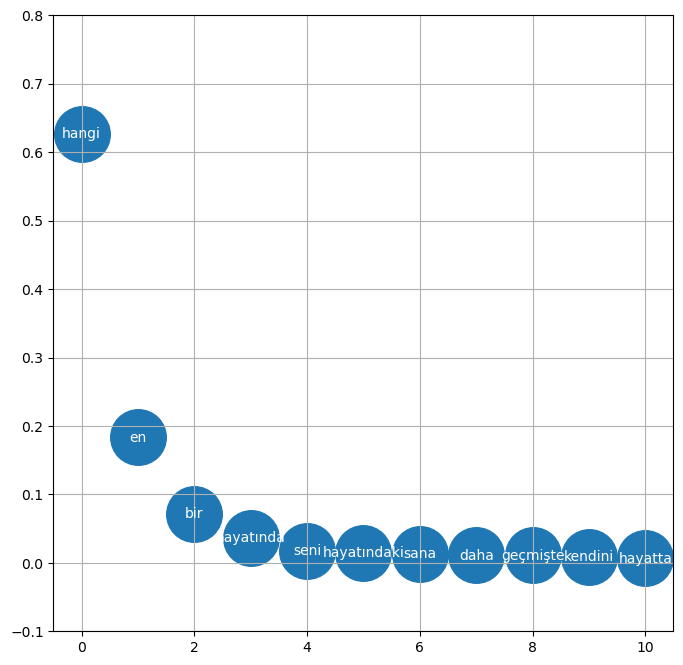

In [258]:
plt.figure(figsize=(8,8))
plt.scatter(distr.index, distr["Probability"], s=1600)
for i in range(11):
    plt.text(distr.index[i], distr["Probability"][i], distr["words"][i], ha="center", va="center", color='white')
plt.ylim(-0.1,0.8)    
plt.grid('minor')

In [259]:
#sorted(cnt.items(),key = lambda kv: -kv[1])[:11]  #first is word second its index value and least is count

In [260]:
X_train[:1]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   4, 483, 624, 242]])

In [266]:
countiee=0
for _ in range(20):
    out = []
    #length=np.random.randint(4,max_seq_l+3)   #optional, needs another kind of configuration
    first = np.array([[random.choice(morta)]])
    ar1=np.array(pad_sequences(first.tolist(),maxlen=max_seq_l-1,padding='pre'))
    firstword = niw[first[0][0]]
    out.append(firstword)
    
    while True:
        
        predi = np.array([torch.multinomial(torch.Tensor(model.predict(ar1,verbose=0)), num_samples=1).item()])
        ar1 = np.append(ar1,predi)   #updating array with new predictions
        ar1 = np.delete(ar1,0).reshape(1,-1)  #deleting a zero from start for maintaining shape
        wordie = niw[predi[0]]  # new index to word dictionary
        out.append(wordie)
        if predi[0] == 1:    # if "?" mark comes out it stops then prints word
            break
    la=' '.join(out)
    if la not in proque:
        countiee +=1
        print(la[:1].upper()+la[1:])
print(f"\n\nNew Questions :{countiee} \nOverfitting questions :{_+1-countiee}")

Hangi ünlünün faaliyetlerde bulunmaktan seversin ?
Hangi müzik türünü en en seversin ?
Hangi hayvana oyunu karakteri seni en çok etkiler ?
Hangi evcil hayvanları yaşamak istersin ?
Hangi bilim dalında gitmek istersin ?
En sevdiğin süper dalı nedir ?
Hangi müzik aletlerini çalmayı öğrenmek için tercih lezzetli olduğunu düşünüyorsun ?
Hangi renk seni en çok yapmayı edersin ?
Hangi evcil hayvanları kıyafetlerini giymek istersin ?
En sevdiğin müze karakterinin gitmek nedir ?
Bir süper dalı seni mutlu eder ?
En çok ne zaman kendine bir şey öğrendin ?
Hangi sporu ülkede seversin ve asla ediyorsun ?
Bir gün içinde en sevdiğin yemeklerden üçünü söyler mısın ?
Hangi hobilerin seni etkiledi ?


New Questions :15 
Overfitting questions :5


In [264]:
proque

['hangi kitabın seni en çok etkiledi ?',
 'hangi kurgusal karakterin kıyafetlerini giymek istersin ?',
 'hangi tarihi olaya tanıklık etmek isterdin ?',
 'hangi müzik türünü en çok seversin ?',
 'hangi ilde yaşamak istersin ?',
 'hangi sporda daha başarılı olduğunu düşünüyorsun ?',
 'hayatında sana en çok ilham veren insan kimdir ?',
 'hayatında bir şeyleri yeniden yapabilseydin, neyi yapardın ?',
 'hangi animasyon filmini izlemeyi en çok seversin ?',
 'hangi ülkede yaşamak istersin ve neden ?',
 'en çok hangi meyveyi seversin? neden ?',
 'en sevdiğin oyun hangisi? hangi özellikleri seni cezbeder ?',
 'hangi yılbaşı geleneğini en çok seversin ?',
 'hangi müzisyenin konserine gitmek isterdin ?',
 'hangi tarihi döneme gitmek isterdin ?',
 'hangi ülkenin yemeklerini daha çok seversin ?',
 'hangi kahramanlık hikayesi seni en çok etkiledi ?',
 'hangi yemek tarifini öğrenmek istersin ?',
 'seni en çok korkutan şey nedir ?',
 'en sevdiğin spor dalı nedir ?',
 'hangi yiyecekleri sevmezsin ?',
 